# Writing CUDA kernels in Python

In this session we learn about how we can write simple kernels in python, translate them into C++ code using an LLM and leverage pytorch's tool to compile the kernel into a module we can load and execute from python.

Video link: https://www.youtube.com/watch?v=4sgKnKbR-WE

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/b4rdos/gpu-mode-notes/blob/master/notebooks/03-kernels-in-python/03-kernels-in-python.ipynb)

In [1]:
def in_colab() -> bool:
    try:
        import google.colab
        return True
    except ImportError:
        return False


IN_COLAB = in_colab()
image_path = "./data/cats-window.jpg"
if IN_COLAB:
    image_path = "https://raw.githubusercontent.com/b4rdos/gpu-mode-notes/refs/heads/main/notebooks/03-kernels-in-python/data/cats-window.jpg"

In [5]:
import os
import math
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision as tv
import torchvision.transforms.functional as tvf

from torchvision import io
from torch.utils.cpp_extension import load_inline

Let's load the image as a tensor

In [3]:
def load_image():
    if IN_COLAB:
        import requests
        return requests.get(image_path, stream=True).raw
    else:
        return open(image_path, "rb")

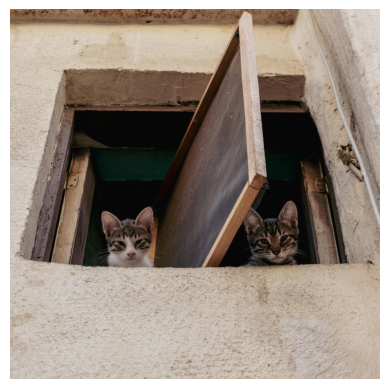

In [9]:
# prompt: Use PIL.Image with image loaded in bytes.
bytes_data = load_image()
img_pil = Image.open(bytes_data)
plt.imshow(img_pil)
plt.axis('off')
plt.show()

In [10]:
# prompt: Convert pil image to torch tensor


img_tensor = tvf.to_tensor(img_pil)
print(f"Shape of torch tensor: {img_tensor.shape}")

Shape of torch tensor: torch.Size([3, 3794, 3794])


In [11]:
def show_img(x, figsize=(4, 3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis("off")
    if len(x.shape)==3: x = x.permute(1, 2, 0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [14]:
img2 = tvf.resize(img_tensor, 150, antialias=True)
ch, h, w = img2.shape
print(ch, h, w)

3 150 150


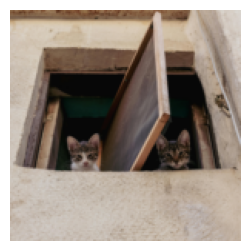

In [ ]:
show_img(img2)